In [22]:
import os
import csv
import carla
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import gymnasium as gym
from gymnasium import spaces
from collections import deque
import copy
import time
import math

In [23]:
class Vector:
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z

In [44]:
threshold = 2


In [53]:
# Configuration
CSV_FILE = "waypoint.csv"
EPISODES = 500
STEPS = 50000
BATCH_SIZE = 64
GAMMA = 0.99
LEARNING_RATE = 1e-3
MEMORY_SIZE = 10000
EPSILON_DECAY = 0.995
MIN_EPSILON = 0.01

In [54]:
class DQNAgent(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQNAgent, self).__init__()
        self.action_size = action_size
        self.state_size = state_size
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [55]:
def optimize_model(agent, target_agent, memory, optimizer, batch_size, gamma):
    if len(memory) < batch_size:
        return

    batch = random.sample(memory, batch_size)
    state_batch, action_batch, reward_batch, next_state_batch, done_batch = zip(*batch)

    state_batch = torch.cat(state_batch)
    action_batch = torch.cat(action_batch)
    reward_batch = torch.cat(reward_batch)
    next_state_batch = torch.cat(next_state_batch)
    done_batch = torch.cat(done_batch)

    current_Q_values = agent(state_batch).gather(1, action_batch)
    next_max_q = target_agent(next_state_batch).detach().max(1)[0].unsqueeze(1)
    target_Q_values = reward_batch + (gamma * next_max_q * (1 - done_batch))

    loss = nn.SmoothL1Loss()(current_Q_values, target_Q_values)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

def epsilon_greedy_policy(agent, state, epsilon):
    if random.random() > epsilon:
        with torch.no_grad():
            return agent(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(agent.action_size)]], dtype=torch.long)
    
def waypoint_based_action(vehicle, next_waypoint):
    current_transform = vehicle.get_transform()
    current_yaw = current_transform.rotation.yaw

    next_location = carla.Location(x=next_waypoint[0], y=next_waypoint[1])
    desired_yaw = math.degrees(math.atan2(next_location.y - current_transform.location.y, 
                                          next_location.x - current_transform.location.x))
    yaw_diff = (desired_yaw - current_yaw) % 360

    if yaw_diff > 180:
        yaw_diff -= 360

    if yaw_diff > 5:
        action = 3  # Steer right
    elif yaw_diff < -5:
        action = 2  # Steer left
    else:
        action = 0  # Go straight
#     print(f'action decided: {action}, current yaw: {yaw_diff}')
    return torch.tensor([[action]], dtype=torch.long)

    

def read_waypoints(file_path):
    waypoints = []
    with open(file_path, 'r') as csvfile:
        csvreader = csv.reader(csvfile)
        for row in csvreader:
            x, y, yaw = map(float, row)
            waypoints.append((x, y, yaw))
            
    return waypoints

class CarlaEnv(gym.Env):
    def __init__(self, vehicle, waypoints):
        super(CarlaEnv, self).__init__()
        self.vehicle = vehicle
        self.waypoints = waypoints
        self.current_waypoint_index = 0

        self.action_space = spaces.Discrete(4)  # [throttle, brake, steer_left, steer_right]
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(5,), dtype=np.float32)

        self.lane_invasion = False
#         print('CarlaEnv made')
#         self.lane_invasion_sensor = self._spawn_lane_invasion_sensor()
        
#     def _spawn_lane_invasion_sensor(self):
#         sensor_bp = self.world.get_blueprint_library().find('sensor.other.lane_invasion')
#         sensor_transform = carla.Transform(carla.Location(x=2.5, z=0.7))
#         sensor = self.world.spawn_actor(sensor_bp, sensor_transform, attach_to=self.vehicle)
#         sensor.listen(lambda event: self._on_lane_invasion(event))
#         return sensor

    def _on_lane_invasion(self, event):
#         print("lane invasion detected")
        self.lane_invasion = True    

    def reset(self):
        vel = carla.Vector3D()
        vel.x = 0
        vel.y = 0
        vel.z = 0
        self.vehicle.set_target_velocity(vel)
        x, y, yaw = self.waypoints[0]
        transform = carla.Transform(carla.Location(x, y), carla.Rotation(yaw=yaw))
        self.vehicle.set_transform(transform)
#         print("reset done")
        return self._get_observation()

    def step(self, action):
        throttle = 0
        brake = 0
        steer = 0

        if action == 0:
            throttle = 1.0
        elif action == 1:
            brake = 1.0
        elif action == 2:
            steer = -1.0
        
        elif action == 3:
            steer = 1.0
            

        control = carla.VehicleControl(throttle=throttle, brake=brake, steer=steer)
        self.vehicle.apply_control(control)

        next_waypoint = self.waypoints[self.current_waypoint_index]
        next_waypoint_location = carla.Location(x=next_waypoint[0], y=next_waypoint[1])
        current_location = self.vehicle.get_location()
        distance = current_location.distance(next_waypoint_location)

        if distance < threshold:
            self.current_waypoint_index += 1
            if self.current_waypoint_index >= len(self.waypoints):
                self.current_waypoint_index = 0

        reward = self._get_reward(distance, control)

        done = False
        if self.current_waypoint_index == len(self.waypoints) - 1:
            done = True
#         print (f'step taken: Throttle: {throttle} and steer: {steer}')
        return self._get_observation(), reward, done, {}

    def _get_observation(self):
        location = self.vehicle.get_location()
        orientation = self.vehicle.get_transform().rotation.yaw
        speed = self.vehicle.get_velocity()
        speed = np.sqrt(speed.x**2 + speed.y**2 + speed.z**2)
        next_waypoint = self.waypoints[self.current_waypoint_index]
        next_waypoint_location = carla.Location(x=next_waypoint[0], y=next_waypoint[1])
        distance = location.distance(next_waypoint_location)
#         print('observation taken')
        return np.array([location.x, location.y, orientation, speed, distance])


    def _get_reward(self, distance, control):
        reward = 0
        if control.throttle > 0:
            reward += 0
        if distance < threshold:
            reward += 10    
        # Apply a large negative reward for lane invasion
        if self.lane_invasion:
            reward -= 1000  # Adjust the value as needed
            self.lane_invasion = True    
#         print('reward calculated')    
        return reward

In [56]:
scores = []
def main():
    # Set up RL agent
    state_size = 5
    action_size = 4
    agent = DQNAgent(state_size, action_size)
    target_agent = copy.deepcopy(agent)
    optimizer = optim.Adam(agent.parameters(), lr=LEARNING_RATE)
    memory = deque(maxlen=MEMORY_SIZE)
    epsilon = 1.0
    try:
        # Read waypoints from CSV
        waypoints = read_waypoints(CSV_FILE)

        # Connect to CARLA server
        client = carla.Client('localhost', 2000)
        client.set_timeout(10.0)

        # Load CARLA world
        world = client.get_world()
        world.set_weather(carla.WeatherParameters.ClearNoon)
        blueprint_library = world.get_blueprint_library()

        # Spawn vehicle
        vehicle_bp = random.choice(blueprint_library.filter('wrangler_rubicon'))
        spawn_point = carla.Transform(carla.Location(x=-23.6,y=137.5,z=1),carla.Rotation(yaw=0))
        vehicle = world.spawn_actor(vehicle_bp, spawn_point)

        sensor_bp = world.get_blueprint_library().find('sensor.other.lane_invasion')
        sensor_transform = carla.Transform(carla.Location(x=2.5, z=0.7))
        sensor = world.spawn_actor(sensor_bp, sensor_transform, attach_to=vehicle)
        sensor.listen(lambda event: env._on_lane_invasion(event))

        # Create CARLA environment
        env = CarlaEnv(vehicle, waypoints)

        # Train the DQN agent
        for episode in range(EPISODES):
            state = env.reset()
            state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            episode_reward = 0
            env.current_waypoint_index = 0
            env.lane_invasion = False
            for _ in range(STEPS):
#                 action = epsilon_greedy_policy(agent, state, epsilon)
                
                next_waypoint = env.waypoints[env.current_waypoint_index]
                action = waypoint_based_action(vehicle, next_waypoint)

                
                next_state, reward, done, _ = env.step(action.item())
                next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)

                memory.append((state, action, torch.tensor([reward], dtype=torch.float32).unsqueeze(0),
                               next_state, torch.tensor([done], dtype=torch.float32).unsqueeze(0)))

                state = next_state
                episode_reward += reward
                epsilon = max(epsilon * EPSILON_DECAY, MIN_EPSILON)

                optimize_model(agent, target_agent, memory, optimizer, BATCH_SIZE, GAMMA)
                if env.lane_invasion:
                    done = True
                
                if done:
                    break

            # Update target network
            if episode % 10 == 0:
                target_agent.load_state_dict(agent.state_dict())

            print(f"Episode {episode}, Total Reward: {episode_reward}, Epsilon: {epsilon}")
            scores.append(episode_reward)
            time.sleep(0.01)
        
            
        # Save the trained model
        torch.save(agent.state_dict(), "dqn_agent.pth")
    finally:
        # Destroy the vehicle in CARLA
        sensor.destroy()                      
        vehicle.destroy()
        print("All Cleared")

In [57]:
if __name__ == "__main__":
    main()

Episode 0, Total Reward: 270, Epsilon: 0.01
Episode 1, Total Reward: 280, Epsilon: 0.01
Episode 2, Total Reward: 270, Epsilon: 0.01
Episode 3, Total Reward: 270, Epsilon: 0.01
Episode 4, Total Reward: 0, Epsilon: 0.01
Episode 5, Total Reward: 210, Epsilon: 0.01
Episode 6, Total Reward: 0, Epsilon: 0.01
Episode 7, Total Reward: 240, Epsilon: 0.01
Episode 8, Total Reward: 200, Epsilon: 0.01
Episode 9, Total Reward: 280, Epsilon: 0.01
Episode 10, Total Reward: 280, Epsilon: 0.01
Episode 11, Total Reward: 280, Epsilon: 0.01
Episode 12, Total Reward: 280, Epsilon: 0.01
Episode 13, Total Reward: 280, Epsilon: 0.01
Episode 14, Total Reward: 270, Epsilon: 0.01
Episode 15, Total Reward: 310, Epsilon: 0.01
Episode 16, Total Reward: 290, Epsilon: 0.01
Episode 17, Total Reward: 290, Epsilon: 0.01
Episode 18, Total Reward: 190, Epsilon: 0.01
Episode 19, Total Reward: 280, Epsilon: 0.01
Episode 20, Total Reward: 0, Epsilon: 0.01
Episode 21, Total Reward: 140, Epsilon: 0.01
Episode 22, Total Reward: 

Episode 182, Total Reward: 280, Epsilon: 0.01
Episode 183, Total Reward: 310, Epsilon: 0.01
Episode 184, Total Reward: 590, Epsilon: 0.01
Episode 185, Total Reward: 310, Epsilon: 0.01
Episode 186, Total Reward: 270, Epsilon: 0.01
Episode 187, Total Reward: 360, Epsilon: 0.01
Episode 188, Total Reward: 280, Epsilon: 0.01
Episode 189, Total Reward: 310, Epsilon: 0.01
Episode 190, Total Reward: 310, Epsilon: 0.01
Episode 191, Total Reward: 290, Epsilon: 0.01
Episode 192, Total Reward: 0, Epsilon: 0.01
Episode 193, Total Reward: 280, Epsilon: 0.01
Episode 194, Total Reward: 280, Epsilon: 0.01
Episode 195, Total Reward: 280, Epsilon: 0.01
Episode 196, Total Reward: 590, Epsilon: 0.01
Episode 197, Total Reward: 270, Epsilon: 0.01
Episode 198, Total Reward: 270, Epsilon: 0.01
Episode 199, Total Reward: 300, Epsilon: 0.01
Episode 200, Total Reward: 280, Epsilon: 0.01
Episode 201, Total Reward: 280, Epsilon: 0.01
Episode 202, Total Reward: 350, Epsilon: 0.01
Episode 203, Total Reward: 300, Epsi

Episode 361, Total Reward: 590, Epsilon: 0.01
Episode 362, Total Reward: 280, Epsilon: 0.01
Episode 363, Total Reward: 0, Epsilon: 0.01
Episode 364, Total Reward: 290, Epsilon: 0.01
Episode 365, Total Reward: 290, Epsilon: 0.01
Episode 366, Total Reward: 280, Epsilon: 0.01
Episode 367, Total Reward: 280, Epsilon: 0.01
Episode 368, Total Reward: 0, Epsilon: 0.01
Episode 369, Total Reward: 310, Epsilon: 0.01
Episode 370, Total Reward: 300, Epsilon: 0.01
Episode 371, Total Reward: 280, Epsilon: 0.01
Episode 372, Total Reward: 320, Epsilon: 0.01
Episode 373, Total Reward: 280, Epsilon: 0.01
Episode 374, Total Reward: 290, Epsilon: 0.01
Episode 375, Total Reward: 280, Epsilon: 0.01
Episode 376, Total Reward: 590, Epsilon: 0.01
Episode 377, Total Reward: 280, Epsilon: 0.01
Episode 378, Total Reward: 300, Epsilon: 0.01
Episode 379, Total Reward: 270, Epsilon: 0.01
Episode 380, Total Reward: 240, Epsilon: 0.01
Episode 381, Total Reward: 0, Epsilon: 0.01
Episode 382, Total Reward: 270, Epsilon:

In [ ]:
[(-23.597307205200195, 137.0661163330078, 0.3521270751953125), (-23.55245018005371, 137.06639099121094, 0.3521270751953125), (-22.7453670501709, 137.07135009765625, 0.3521270751953125), (-20.906631469726562, 137.0826416015625, 0.3521270751953125), (-17.937257766723633, 137.10089111328125, 0.3521270751953125), (-14.001919746398926, 137.1250762939453, 0.3521270751953125), (-9.950039863586426, 137.1499786376953, 0.3521270751953125), (-5.889456748962402, 137.17494201660156, 0.3521270751953125), (-1.899501919746399, 137.199462890625, 0.3521270751953125), (2.1661477088928223, 137.22511291503906, 0.4448866546154022), (6.19586181640625, 137.272705078125, 0.9083132743835449), (10.269187927246094, 137.3509063720703, 1.1775866746902466), (14.2843017578125, 137.41847229003906, 0.7351945042610168), (18.339458465576172, 137.4542999267578, 0.32044845819473267), (22.50907325744629, 137.47763061523438, 0.32044845819473267), (26.559429168701172, 137.50027465820312, 0.32044845819473267), (30.52979850769043, 137.52249145507812, 0.32044845819473267), (34.64375305175781, 137.54550170898438, 0.32044845819473267), (38.67440414428711, 137.5680389404297, 0.32044845819473267), (42.72395324707031, 137.59068298339844, 0.32044845819473267), (46.77073287963867, 137.6133270263672, 0.32044845819473267), (50.81194305419922, 137.63592529296875, 0.32044845819473267), (54.853050231933594, 137.6585235595703, 0.32044845819473267), (58.88810729980469, 137.68109130859375, 0.32044845819473267), (62.942222595214844, 137.70376586914062, 0.32044845819473267), (67.03063201904297, 137.65335083007812, -3.2371885776519775), (70.9086685180664, 137.23367309570312, -9.11582088470459), (75.0324478149414, 136.33480834960938, -15.477066040039062), (78.87277221679688, 135.04766845703125, -21.581363677978516), (82.56835174560547, 133.35215759277344, -27.709299087524414), (86.10346221923828, 131.243896484375, -33.912811279296875), (89.42973327636719, 128.73248291015625, -40.19452667236328), (92.34596252441406, 125.9930419921875, -46.22463607788086), (94.98958587646484, 122.92913818359375, -51.8900260925293), (97.37153625488281, 119.6259536743164, -56.51860427856445), (99.46526336669922, 116.16654968261719, -61.11445236206055), (101.27847290039062, 112.54296112060547, -65.71971130371094), (102.79850006103516, 108.77535247802734, -70.33717346191406), (104.00875854492188, 104.9033432006836, -74.94791412353516), (104.90636444091797, 100.9328842163086, -79.574462890625), (105.48133087158203, 96.897705078125, -84.20702362060547), (105.7305908203125, 92.72013092041016, -88.96361541748047), (105.76097869873047, 88.73402404785156, -89.6092529296875), (105.78852081298828, 84.69615173339844, -89.6092529296875), (105.8160629272461, 80.65655517578125, -449.6092224121094), (105.84347534179688, 76.637939453125, -449.6092224121094), (105.87109375, 72.58792114257812, -449.6092224121094), (105.89848327636719, 68.57239532470703, -449.6092224121094), (105.92497253417969, 64.6881332397461, -449.6092224121094), (105.94950866699219, 61.08949661254883, -449.6092224121094), (105.9720458984375, 57.78582763671875, -449.6092224121094), (105.99339294433594, 54.65508270263672, -449.6092224121094), (106.01345825195312, 51.713321685791016, -89.6092529296875), (106.03005981445312, 49.278953552246094, -89.6092529296875), (106.03091430664062, 49.153141021728516, -89.6092529296875), (106.03091430664062, 49.15312957763672, -89.6092529296875), (106.03091430664062, 49.1533203125, -89.6092529296875), (106.03091430664062, 49.153316497802734, -89.6092529296875), (106.03091430664062, 49.153316497802734, -89.6092529296875), (106.03091430664062, 49.153316497802734, -89.6092529296875)]

In [35]:
math.atan2(1,1)*180/math.pi

45.0

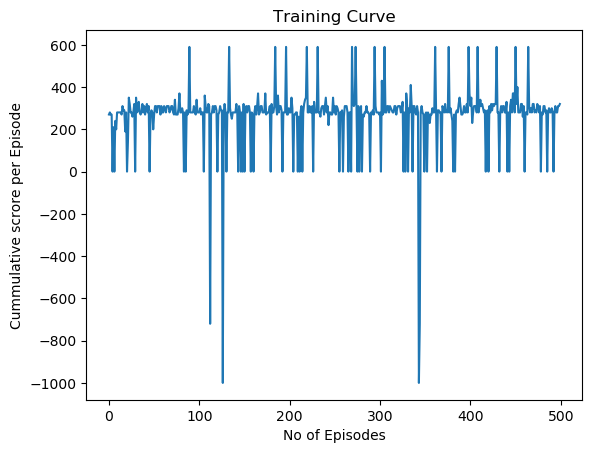

In [59]:
import matplotlib.pyplot as plt
plt.plot(scores)
plt.title("Training Curve")
plt.xlabel('No of Episodes')
plt.ylabel("Cummulative scrore per Episode")
plt.show()